# Introduction - Sell in May and Go Away ?  

This notebook captures 10 years of daily historical data from ST Louis Federal Reserve's database for the following 5 securities:  

- S&P 500  
- 10 Year Treaury Bond  
- Gold  
- Oil  
- Bitcoin  

The goal is to answer several questions that could help various firms in the financial industry capitalize on patterns in market data.  Another goal is to explain relationships among various securities and provide a better understanding of day to day movements in price.  Accurately predicting daily price change can be profitable for short term trading while predicting medium or long term price change can be very beneficial for wide ranging planning and stretegic purposes for many, many different businesses and industries.  

This notebook will follow the outline:  

1.  Weather Data  

2.  Financial Data  
    A.  Question:  Do different days of the week yield significant price change ?  
    B.  Question:  Do 'winter' months perform better than 'summer' months ?  
    
    There has been much debate about wheather the winter months perform better than the summer.  Hence, the title of this notebook.  Many believe that the winter offers better returns overall for equities and one should consider buying equities in early November and sell in early May.  This notebook will answer the question.  

    C.  Question:  Does the 3rd Presidential Year yield better results in the 'winter' months vs. 'summer' ?  

    Similarly, there is at least one extensive study that makes the point that the winter of the 3rd Presidential Year performs better than any other season.  This notebook axamines this claim.  The link to the study is provided in this section.  
    
    D.  Question:  Does any month of the S&P 500 over the past 10 years perform significantly better than any other ?  
    E.  Question:  Is it possible to build a supervised learning model to predict the daily price change of gold just by using day of the week as the only feature ?  
    
3.  Weather and Financial Data Combined  
    A.  Question:  Does the daily temperature or amount of sunshine in NYC affect the price change of the S&P 500 ?  
    B.  Question:  Is it possible to build a supervised learning model that uses the day of the week, month, day of month and weather data to predict daily price change of the S&P 500 ?  
    C.  Question:  Is it possible to build an unsupervised learning model to identify relationships among the 5 securites previously analyzed in this study ?  

Fist step -- Import necessary modules and libraries.

In [1]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy import stats
import sklearn
from sklearn import preprocessing
from sklearn import linear_model
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.cluster import MeanShift, estimate_bandwidth
%matplotlib inline

# 1.  Weather Data  

Import weather data for New York City from meteoblue.com.

In [2]:
# Use pandas read_csv command to import the local csv file
dfw = pd.read_csv('nyc_daily.csv', skiprows=11, sep=';')
dft = pd.read_csv('temp_and_snow.csv', skiprows=11, sep=';')
dfw.head()

,Year,Month,Day,Hour,Minute,Sunshine Duration daily sum [sfc]
0,2009,6,25,0,0,-726.93
1,2009,6,26,0,0,418.70
2,2009,6,27,0,0,743.23
3,2009,6,28,0,0,436.08
4,2009,6,29,0,0,848.28


In [3]:
dft.head()

,Year,Month,Day,Hour,Minute,Temperature daily mean [2 m above gnd],Snowfall Amount (high resolution) daily sum [sfc],Temperature daily max [2 m above gnd],Temperature daily min [2 m above gnd]
0,2009,6,25,0,0,71.72,0.0,81.24,64.02
1,2009,6,26,0,0,76.91,0.0,88.19,66.18
2,2009,6,27,0,0,76.34,0.0,83.91,65.85
3,2009,6,28,0,0,72.35,0.0,78.78,66.54
4,2009,6,29,0,0,75.43,0.0,84.19,65.20


Drop some of the data not needed for now; rename a column and drop the first (and strange) negative number.

In [4]:
# drop the Hour and Minute columns
dfw.drop(['Hour', 'Minute'], axis=1, inplace=True)
dft.drop(['Hour', 'Minute'], axis=1, inplace=True)

# change long named column to just 'Sun'
dfw.columns = ['Year', 'Month', 'Day', 'Sun']
dft.columns = ['Year', 'Month', 'Day', 'avg_temp', 'snow', 'max', 'min']

# Convert negative numbers to zero
dfw[dfw < 0] = 0
dft[dft < 0] = 0

# drop 'snow', 'max', 'min' for now
dft.drop(['snow', 'max', 'min'], axis=1, inplace=True)

print(dfw.columns)
print(dft.columns)

Index(['Year', 'Month', 'Day', 'Sun'], dtype='object')
Index(['Year', 'Month', 'Day', 'avg_temp'], dtype='object')


Next, look at the first five lines of the dataframe.

In [5]:
dfw.head()

,Year,Month,Day,Sun
0,2009,6,25,0.00
1,2009,6,26,418.70
2,2009,6,27,743.23
3,2009,6,28,436.08
4,2009,6,29,848.28


Set up the data to plot the number of minutes of sun per day over the entire time horizon.

In [6]:
dfw_plot = dfw
dfw_plot['dt'] = pd.to_datetime((dfw.Year*10000+dfw.Month*100+dfw.Day).apply(str),format='%Y%m%d')
dfw_plot.columns = ['Year', 'Month', 'Day', 'Sun', 'dt']
dfw_plot.index = pd.to_datetime(dfw_plot.dt)
dfw_plot.drop(['Year'], axis=1, inplace=True)
dfw_plot.drop(['Month'], axis=1, inplace=True)
dfw_plot.drop(['Day'], axis=1, inplace=True)
dfw_plot.drop(['dt'], axis=1, inplace=True)

dft['dt'] = pd.to_datetime((dft.Year*10000+dft.Month*100+dft.Day).apply(str),format='%Y%m%d')
dft.columns = ['Year', 'Month', 'Day', 'avg_temp', 'dt']
dft.index = pd.to_datetime(dft.dt)
dft.drop(['Year'], axis=1, inplace=True)
dft.drop(['Month'], axis=1, inplace=True)
dft.drop(['Day'], axis=1, inplace=True)
dft.drop(['dt'], axis=1, inplace=True)

The index has been changed to a date-time object.  Next, the plot shows the amount of sunshine in minutes for New York City.

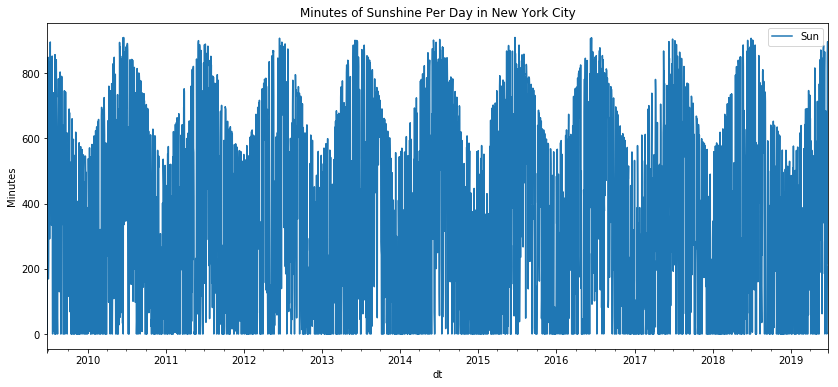

In [7]:
dfw_plot.plot(figsize=(14, 6))
plt.title('Minutes of Sunshine Per Day in New York City')
plt.ylabel('Minutes')
plt.show()

The seasonality is obvious from the plot above.  Many more minutes of sunshine in the summer months than in the winter.  Does this have any affect on trading activity or price change in the equtiy markets ?  New York City was chosen because it is a financial hub, wall street is there, the largest banks and hedge funds are there, and it's a generally a massively influencial city in the world of Finance.  

# 2.  Financial Data  

First, read in all of the data from FRED in csv format.  Then convert the price column to a number, and remove NaN values.

In [8]:
# read in all of the local csv files into pandas:
df = pd.read_csv('SP500.csv')
df_10 = pd.read_csv('DGS10.csv')
df_10_10 = pd.read_csv('DGS10_10.csv')
df_gold = pd.read_csv('gold.csv')

# copy the gold dataframe for later use:
df_goldc = df_gold.copy()

df_oil = pd.read_csv('oil.csv')
df_btc = pd.read_csv('btc.csv')


# Convert price to a number, with coersion to throw NA's if conversion not possible
df['price'] = pd.to_numeric(df.SP500, errors='coerce')
df_10['price'] = pd.to_numeric(df_10.DGS10, errors='coerce')
df_10_10['price'] = pd.to_numeric(df_10_10.DGS10, errors='coerce')
df_gold['price'] = pd.to_numeric(df_gold.GOLDAMGBD229NLBM, errors='coerce')
df_oil['price'] = pd.to_numeric(df_oil.DCOILWTICO, errors='coerce')
df_btc['price'] = pd.to_numeric(df_btc.CBBTCUSD, errors='coerce')


# Remove NA's
df.dropna(inplace=True)
df_10.dropna(inplace=True)
df_10_10.dropna(inplace=True)
df_gold.dropna(inplace=True)
df_oil.dropna(inplace=True)
df_btc.dropna(inplace=True)

The next cell looks at the first 5 lines of the S&P 500 data.

In [9]:
df.head()

,DATE,SP500,price
0,2009-06-26,918.90,918.90
1,2009-06-29,927.23,927.23
2,2009-06-30,919.32,919.32
3,2009-07-01,923.33,923.33
4,2009-07-02,896.42,896.42


The next plot, shows the graph of the S&P 500 data as an example.  

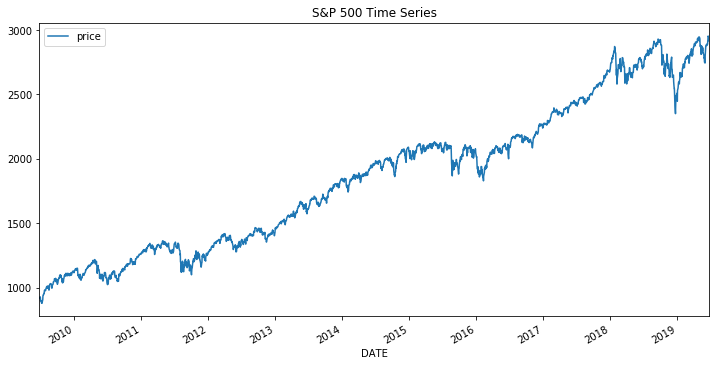

In [10]:
df.index = pd.to_datetime(df.DATE)
df.plot(figsize=(12, 6))
plt.title('S&P 500 Time Series')
plt.show()

As seen in the plot above, in the middle of 2009, the price was about 900 and then rises to the value of about 3000 by the end of June, 2019.  The next plot shows the 10 Yr Bond prices from the mid-1960's to June, 2019.

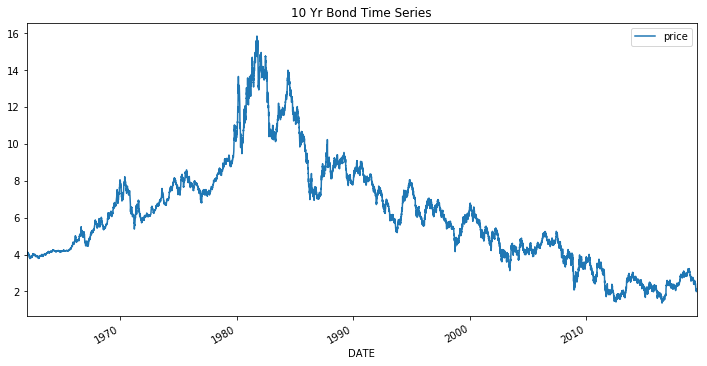

In [11]:
df_10.index = pd.to_datetime(df_10.DATE)
df_10.plot(figsize=(12, 6))
plt.title('10 Yr Bond Time Series')
plt.show()

The next step separates the weekday, day of month, month and year from the date object for all 5 securities studied in this notebook:  
- S&P 500  
- 10 Yr Bond 
- Gold  
- Oil  
- Bitcoin

In [12]:
# For S&P 500
df['date_time'] = pd.to_datetime(df['DATE'])

df['weekday'] = df.date_time.dt.weekday
df['day'] = df.date_time.dt.day
df['month'] = df.date_time.dt.month
df['year'] = df.date_time.dt.year

# For 10 Yr Bond
df_10['date_time'] = pd.to_datetime(df_10['DATE'])

df_10['weekday'] = df_10.date_time.dt.weekday
df_10['day'] = df_10.date_time.dt.day
df_10['month'] = df_10.date_time.dt.month
df_10['year'] = df_10.date_time.dt.year

# For 10 Yr Bond (last 10 years only)
df_10_10['date_time'] = pd.to_datetime(df_10_10['DATE'])

df_10_10['weekday'] = df_10_10.date_time.dt.weekday
df_10_10['day'] = df_10_10.date_time.dt.day
df_10_10['month'] = df_10_10.date_time.dt.month
df_10_10['year'] = df_10_10.date_time.dt.year

# For gold (last 10 years only)
df_gold['date_time'] = pd.to_datetime(df_gold['DATE'])

df_gold['weekday'] = df_gold.date_time.dt.weekday
df_gold['day'] = df_gold.date_time.dt.day
df_gold['month'] = df_gold.date_time.dt.month
df_gold['year'] = df_gold.date_time.dt.year

# For oil (last 10 years only)
df_oil['date_time'] = pd.to_datetime(df_oil['DATE'])

df_oil['weekday'] = df_oil.date_time.dt.weekday
df_oil['day'] = df_oil.date_time.dt.day
df_oil['month'] = df_oil.date_time.dt.month
df_oil['year'] = df_oil.date_time.dt.year

# For bitcoin
df_btc['date_time'] = pd.to_datetime(df_btc['DATE'])

df_btc['weekday'] = df_btc.date_time.dt.weekday
df_btc['day'] = df_btc.date_time.dt.day
df_btc['month'] = df_btc.date_time.dt.month
df_btc['year'] = df_btc.date_time.dt.year

0 = Monday  
1 = Tuesday  
2 = Wednesday  
3 = Thursday  
4 = Friday  

Prices are the closing price for the day listed.  The next cell shows the last few lines of the S&P 500 dataframe.

In [13]:
df.tail()

,DATE,SP500,price,date_time,weekday,day,month,year
DATE,,,,,,,,
2019-06-19,2019-06-19,2926.46,2926.46,2019-06-19,2,19,6,2019
2019-06-20,2019-06-20,2954.18,2954.18,2019-06-20,3,20,6,2019
2019-06-21,2019-06-21,2950.46,2950.46,2019-06-21,4,21,6,2019
2019-06-24,2019-06-24,2945.35,2945.35,2019-06-24,0,24,6,2019
2019-06-25,2019-06-25,2917.38,2917.38,2019-06-25,1,25,6,2019


This next step creates a new column in the dataframe that represents the change in price per day - for all 5 securities.

In [14]:
# add a column for the change in price each day
df['change'] = df.price - df.price.shift()
df_10['change'] = df_10.price - df_10.price.shift()
df_10_10['change'] = df_10_10.price - df_10_10.price.shift()
df_gold['change'] = df_gold.price - df_gold.price.shift()
df_goldc['change_g'] = df_gold.price - df_gold.price.shift()
df_oil['change'] = df_oil.price - df_oil.price.shift()
df_btc['change'] = df_btc.price - df_btc.price.shift()

Show the new dataframe for S&P 500 with the 'change' column:

In [15]:
df.tail()

,DATE,SP500,price,date_time,weekday,day,month,year,change
DATE,,,,,,,,,
2019-06-19,2019-06-19,2926.46,2926.46,2019-06-19,2,19,6,2019,8.71
2019-06-20,2019-06-20,2954.18,2954.18,2019-06-20,3,20,6,2019,27.72
2019-06-21,2019-06-21,2950.46,2950.46,2019-06-21,4,21,6,2019,-3.72
2019-06-24,2019-06-24,2945.35,2945.35,2019-06-24,0,24,6,2019,-5.11
2019-06-25,2019-06-25,2917.38,2917.38,2019-06-25,1,25,6,2019,-27.97


Print the overall mean of the price change per day over the 10 year period for the S&P 500.  This gives a benchmark for camparing other metrics later.

In [16]:
# print mean of 'change' column
print(df.change.mean())

0.7946242544731611


### 2. A.  Question:  Do different days of the week yield significant price change ?  

**Answer:**  Yes, for the 10 Yr Bond (last 50 years and last 10 years), Gold and Bitcoin.  No, for S&P 500 and Oil.  The security with the most significant difference over just the past 10 years was **gold**.  The data and steps taken to determine follow:  first, sum the daily price changes for each security.


In [17]:
# For S&P 500
print(df.loc[df['weekday'] == 0, 'change'].sum())
print(df.loc[df['weekday'] == 1, 'change'].sum())
print(df.loc[df['weekday'] == 2, 'change'].sum())
print(df.loc[df['weekday'] == 3, 'change'].sum())
print(df.loc[df['weekday'] == 4, 'change'].sum())

101.3599999999933
641.9000000000053
601.8699999999991
320.37999999999533
332.9700000000071


So, this means that on Mondays, the total change in the value of the S&P 500 index was about +100.  The total change on all Tuesdays was about +640.

In [18]:
# For 10 Yr Bond
print(df_10.loc[df_10['weekday'] == 0, 'change'].sum())
print(df_10.loc[df_10['weekday'] == 1, 'change'].sum())
print(df_10.loc[df_10['weekday'] == 2, 'change'].sum())
print(df_10.loc[df_10['weekday'] == 3, 'change'].sum())
print(df_10.loc[df_10['weekday'] == 4, 'change'].sum())

13.210000000000022
-6.320000000000043
1.0500000000000325
-2.120000000000004
-7.880000000000006


In [19]:
# For 10 Yr Bond (just last 10 years)
print(df_10_10.loc[df_10_10['weekday'] == 0, 'change'].sum())
print(df_10_10.loc[df_10_10['weekday'] == 1, 'change'].sum())
print(df_10_10.loc[df_10_10['weekday'] == 2, 'change'].sum())
print(df_10_10.loc[df_10_10['weekday'] == 3, 'change'].sum())
print(df_10_10.loc[df_10_10['weekday'] == 4, 'change'].sum())

-0.2999999999999974
-0.09999999999999942
1.7399999999999969
-0.8699999999999986
-1.9900000000000015


In [20]:
# For gold (just last 10 years)
print(df_gold.loc[df_gold['weekday'] == 0, 'change'].sum())
print(df_gold.loc[df_gold['weekday'] == 1, 'change'].sum())
print(df_gold.loc[df_gold['weekday'] == 2, 'change'].sum())
print(df_gold.loc[df_gold['weekday'] == 3, 'change'].sum())
print(df_gold.loc[df_gold['weekday'] == 4, 'change'].sum())

# count the number of days where there was no change.
print(df_gold.loc[df_gold['change'] == 0.0, 'change'].count())
print(df_gold.loc[df_gold['change'] == 0.000, 'change'].count())

538.5429999999996
415.8369999999994
-40.4830000000004
-459.0160000000003
93.1730000000016
0
0


In [21]:
# For oil (just last 10 years)
print(df_oil.loc[df_oil['weekday'] == 0, 'change'].sum())
print(df_oil.loc[df_oil['weekday'] == 1, 'change'].sum())
print(df_oil.loc[df_oil['weekday'] == 2, 'change'].sum())
print(df_oil.loc[df_oil['weekday'] == 3, 'change'].sum())
print(df_oil.loc[df_oil['weekday'] == 4, 'change'].sum())

-21.540000000000035
31.520000000000003
23.049999999999805
-30.409999999999826
-13.029999999999951


In [22]:
# For bitcoin
print(df_btc.loc[df_btc['weekday'] == 0, 'change'].sum())
print(df_btc.loc[df_btc['weekday'] == 1, 'change'].sum())
print(df_btc.loc[df_btc['weekday'] == 2, 'change'].sum())
print(df_btc.loc[df_btc['weekday'] == 3, 'change'].sum())
print(df_btc.loc[df_btc['weekday'] == 4, 'change'].sum())
print(df_btc.loc[df_btc['weekday'] == 5, 'change'].sum())
print(df_btc.loc[df_btc['weekday'] == 6, 'change'].sum())

1421.7199999999955
978.4300000000011
-338.36000000000377
-1088.6800000000028
5006.700000000002
6821.430000000004
-853.5099999999965


The next step is to use a t-test to calculate the p-value of the two days of the week that had the biggest price difference.  In order to do this, create the dataframe for each security with new columns for each trading day of the week.  That way, the entire distribution of the data is captured when running the t-test.

In [23]:
# For S&P 500
df['Monday'] = df.change.where(df.weekday == 0)
df['Tuesday'] = df.change.where(df.weekday == 1)
df['Wednesday'] = df.change.where(df.weekday == 2)
df['Thursday'] = df.change.where(df.weekday == 3)
df['Friday'] = df.change.where(df.weekday == 4)

# For 10 Yr Bond
df_10['Monday'] = df_10.change.where(df_10.weekday == 0)
df_10['Tuesday'] = df_10.change.where(df_10.weekday == 1)
df_10['Wednesday'] = df_10.change.where(df_10.weekday == 2)
df_10['Thursday'] = df_10.change.where(df_10.weekday == 3)
df_10['Friday'] = df_10.change.where(df_10.weekday == 4)

# For 10 Yr Bond (last 10 years)
df_10_10['Monday'] = df_10_10.change.where(df_10_10.weekday == 0)
df_10_10['Tuesday'] = df_10_10.change.where(df_10_10.weekday == 1)
df_10_10['Wednesday'] = df_10_10.change.where(df_10_10.weekday == 2)
df_10_10['Thursday'] = df_10_10.change.where(df_10_10.weekday == 3)
df_10_10['Friday'] = df_10_10.change.where(df_10_10.weekday == 4)

# For gold (last 10 years)
df_gold['Monday'] = df_gold.change.where(df_gold.weekday == 0)
df_gold['Tuesday'] = df_gold.change.where(df_gold.weekday == 1)
df_gold['Wednesday'] = df_gold.change.where(df_gold.weekday == 2)
df_gold['Thursday'] = df_gold.change.where(df_gold.weekday == 3)
df_gold['Friday'] = df_gold.change.where(df_gold.weekday == 4)  

# For oil (last 10 years)
df_oil['Monday'] = df_oil.change.where(df_oil.weekday == 0)
df_oil['Tuesday'] = df_oil.change.where(df_oil.weekday == 1)
df_oil['Wednesday'] = df_oil.change.where(df_oil.weekday == 2)
df_oil['Thursday'] = df_oil.change.where(df_oil.weekday == 3)
df_oil['Friday'] = df_oil.change.where(df_oil.weekday == 4)

# For bitcoin
df_btc['Monday'] = df_btc.change.where(df_oil.weekday == 0)
df_btc['Tuesday'] = df_btc.change.where(df_oil.weekday == 1)
df_btc['Wednesday'] = df_btc.change.where(df_oil.weekday == 2)
df_btc['Thursday'] = df_btc.change.where(df_oil.weekday == 3)
df_btc['Friday'] = df_btc.change.where(df_oil.weekday == 4)
df_btc['Saturday'] = df_btc.change.where(df_oil.weekday == 5)
df_btc['Sunday'] = df_btc.change.where(df_oil.weekday == 6)

Now, t-test and p-values:

In [24]:
# For S&P 500
print('For S&P 500:')
print(ttest_ind(df['Monday'].dropna(), df['Tuesday'].dropna()))

# For 10 Yr Bond
print('\nFor 10 Yr Bond:')
print(ttest_ind(df_10['Monday'].dropna(), df_10['Friday'].dropna()))

print('\nFor 10 Yr Bond just last 10 years:')
# For 10 Yr Bond (last 10 years only)
print(ttest_ind(df_10_10['Wednesday'].dropna(), df_10_10['Friday'].dropna()))

print('\nFor gold:')
print(ttest_ind(df_gold['Monday'].dropna(), df_gold['Thursday'].dropna()))

print('\nFor oil:')
print(ttest_ind(df_oil['Tuesday'].dropna(), df_oil['Thursday'].dropna()))

print('\nFor bitcoin:')
# For bitcoin
df_btc = df_btc.fillna(0)
print(ttest_ind(df_btc['Thursday'].dropna(), df_btc['Saturday'].dropna()))

For S&P 500:
Ttest_indResult(statistic=-0.9729604233090785, pvalue=0.3308115971409148)

For 10 Yr Bond:
Ttest_indResult(statistic=4.070425782579718, pvalue=4.757789969930339e-05)

For 10 Yr Bond just last 10 years:
Ttest_indResult(statistic=2.2201929261497884, pvalue=0.026625706685281653)

For gold:
Ttest_indResult(statistic=3.3440189329939844, pvalue=0.0008567701430384474)

For oil:
Ttest_indResult(statistic=1.371972242519745, pvalue=0.17037285733436644)

For bitcoin:
Ttest_indResult(statistic=2.3029987853710954, pvalue=0.02134134968122411)


Next, calculate the F statistics for gold to further prove the significant difference in days of the week return.

In [25]:
# Calc F statistic for gold (last 10 years only)
F, p = stats.f_oneway(
    df_gold['Monday'].dropna(),
    df_gold['Tuesday'].dropna(),
    df_gold['Wednesday'].dropna(),
    df_gold['Thursday'].dropna(),
    df_gold['Friday'].dropna(),
)

# The F statistic.
print(F)

# The probability. A p < .05 would lead us to believe the group means were
# not all similar in the population.
print(p)

3.8675627733544693
0.0038892555965370883


A high F value means that the data does not well support the null hypothesis. ... So a large F value indicates that a linear model is more compatible with the data than a constant average model. These predictors have high F values leading to small p values so they are sufficient for predicting the response.  

A null hypothesis is a hypothesis that says there is no statistical significance between the two variables in the hypothesis.  In the case of gold, there is a roughly **0.3%** probability that the different sums for the day of the week could have happened due to chance.  Therefore, it is likely that there really is a significant difference in the distributions.  

While t-test is used to compare two related samples, f-test is used to test the equality of two populations.

**To summarize the t-test calculations:**

For S&P 500:  
So, this means that on Mondays, the total change in the value of the S&P 500 index was about +100.  The total change on all Tuesdays was about +640.  

For 10 Yr Bond:  
The pvalue here is much less than .05.  Therefore, the difference in price from Monday and Friday, which are the two most extreme price changes in the data, is significant.  In other words the difference here is probably NOT just due to chance and the values are taken from the DIFFERENT populations.  

For Gold:  
A null hypothesis is a hypothesis that says there is no statistical significance between the two variables in the hypothesis.  In the case of gold, since the pvalue is less than 0.05, the null hypotheses cannot be rejected and it would be likely that the two variables indeed have a statistically significant difference.  

For Bitcoin:  
For the case of bitcoin, there is an approximately **2.1%** probability that the difference in sums of Thursday vs. Saturday happened randomly.  Thursday was the lowest value, Saturday was the highest.  

### 2. B.  Question:  Do 'winter' months perform better than 'summer' months ?  

**Answer:**  No, winter did have a slightly higher average daily return, but was found to be insignificant.  The data analysis follows:  

First group by month to see the total sum of the daily price changes by month:


In [26]:
df_month = df.groupby('month').sum()
df_month.head(20)

,price,weekday,day,year,change,Monday,Tuesday,Wednesday,Thursday,Friday
month,,,,,,,,,,
1,378230.08,426,3338,406938,268.09,-135.64,124.86,92.77,51.86,134.24
2,361761.37,402,2767,386783,375.10,-48.96,205.81,13.81,-23.71,228.15
3,417535.75,435,3448,439151,240.67,201.06,-44.14,-12.37,16.65,79.47
4,402318.47,397,3221,417001,247.74,6.40,193.27,139.98,46.25,-138.16
5,416424.88,446,3294,429099,-185.89,61.17,-116.86,-84.02,-75.88,29.70
6,408419.00,425,3315,429052,128.84,-130.05,127.44,53.69,142.01,-64.25
7,375239.75,424,3499,424842,438.02,46.86,94.98,96.46,74.06,125.66
8,397742.10,442,3557,447006,-93.05,-2.68,-18.94,18.88,-158.66,68.35
9,364306.26,430,3282,410745,97.79,-2.69,-20.86,181.24,52.32,-112.22


Looks like May has the weakest return over the past 10 years and July has the strongest.  Is this difference significant or is it just due to random chance ?  If the total return is added for months November to the end of April, the price gain is about **1407**.  This compares to a price gain of just **592** for the months of May through October over the entire 10 year horizon.  It looks like buying the index in early November and selling in early May might be a good strategy.  However, there is a gain for the "summer" months (May - October), so why not just buy and hold all year round ?  Well, the past 10 years has been the longest running bull market in history and 10 years happens to be the total time frame for this study.  More data is needed to examine this concept more robustly.  

Next, add a 'summer' and 'winter' column to see if there is a significant difference in the rate of return:

In [27]:
# add the column for change in the summer months:
df['summer'] = np.where(((df.year > 2008) & ((df.month == 5) | (df.month == 6) | (df.month == 7) | 
            (df.month == 8) | (df.month == 9) | (df.month == 10))), df.change, 0)

# add the column for change winter months:
df['winter'] = np.where(((df.year < 2020) & ((df.month == 11) | (df.month == 12) | (df.month == 1) | 
            (df.month == 2) | (df.month == 3) | (df.month == 4))), df.change, 0)

In [28]:
# print the average daily return for summer months:
print(df.summer.mean())

0.23533598409542744


In [29]:
# print the average daily return for winter months:
print(df.winter.mean())

0.5590659777424484


In [30]:
# execute ttest for the two different columns of summer and winter
ttest_ind(df['summer'].dropna(), df['winter'].dropna())

Ttest_indResult(statistic=-0.969513403992707, pvalue=0.33233572022424096)

The average return for summer vs winter are **0.23** and **0.56**, respectively.  However, this difference is not significant.  The computed pvalue for the distributions is **0.332**, which is too high to conclude anything.  There is a roughly 33% chance that the data of the two distributions came from the same population.  Much too high to draw any conclusions.  

### 2. C.  Question:  Does the 3rd Presidential Year yield better results in the 'winter' months vs. 'summer' ?  

**Answer:**  No, again winter did have a slightly higher average daily return, but was found to be insignificant.  The data analysis follows:  

Now, winter vs summer just in year 3 of Presidential term.  Create new columns to capture the 3rd year data:

In [31]:
# add the column for change in Presidential 3rd year, summer months:
df['yr3s'] = np.where(((df.year == 2011) | (df.year == 2015) | (df.year == 2019))
            & ((df.month == 5) | (df.month == 6) | (df.month == 7) | 
            (df.month == 8) | (df.month == 9) | (df.month == 10)), df.change, 0)

# add the column for change in Presidential 3rd year, winter months:
df['yr3w'] = np.where(((df.year == 2011) | (df.year == 2015) | (df.year == 2019)
                       & (df.month == 1) | (df.month == 2) | 
                       (df.month == 3) | (df.month == 4)), df.change, 0) 
df['yr3w_2'] = np.where(((df.year == 2010) | (df.year == 2014) | (df.year == 2018)
                       & (df.month == 11) | (df.month == 12)), df.change, 0) 
df['yr3w_t'] = df.yr3w + df.yr3w_2

Look at the new dataframe below:

In [32]:
df.head()

,DATE,SP500,price,date_time,weekday,day,month,year,change,Monday,Tuesday,Wednesday,Thursday,Friday,summer,winter,yr3s,yr3w,yr3w_2,yr3w_t
DATE,,,,,,,,,,,,,,,,,,,,
2009-06-26,2009-06-26,918.90,918.90,2009-06-26,4,26,6,2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
2009-06-29,2009-06-29,927.23,927.23,2009-06-29,0,29,6,2009,8.33,8.33,NaN,NaN,NaN,NaN,8.33,0.0,0.0,0.0,0.0,0.0
2009-06-30,2009-06-30,919.32,919.32,2009-06-30,1,30,6,2009,-7.91,NaN,-7.91,NaN,NaN,NaN,-7.91,0.0,0.0,0.0,0.0,0.0
2009-07-01,2009-07-01,923.33,923.33,2009-07-01,2,1,7,2009,4.01,NaN,NaN,4.01,NaN,NaN,4.01,0.0,0.0,0.0,0.0,0.0
2009-07-02,2009-07-02,896.42,896.42,2009-07-02,3,2,7,2009,-26.91,NaN,NaN,NaN,-26.91,NaN,-26.91,0.0,0.0,0.0,0.0,0.0


Calculate the results:

In [33]:
print("Average daily return for summer months in 3rd Presidential Term")
print(df.yr3s.mean())

Average daily return for summer months in 3rd Presidential Term
-0.057595389507154156


In [34]:
print("Average daily return for winter months in 3rd Presidential Term")
print(df.yr3w_t.mean())

Average daily return for winter months in 3rd Presidential Term
0.4523807631160576


In [35]:
ttest_ind(df['yr3s'].dropna(), df['yr3w_t'].dropna())

Ttest_indResult(statistic=-1.4998938416684096, pvalue=0.13370466363760292)

The daily returns for summer and winter months in the 3rd Presidential Term are not significant.  There is definitely a bigger difference in the 3rd Presidential Term compared to overall summer vs. winter.  However, the pvalue is **0.134** which is not less than 0.05.  So, there is a 13% chance that the sample data of each distribution came from the same population.  This is interesting, but not conclusive enough to take strong action.

### 2. D.  Question:  Does any month of the S&P 500 over the past 10 years perform significantly better than any other ?  

**Answer:**  Yes.  The data analysis follows:  

First, look at the monthly totals, then create the month column of the dataframe to execute a t-test for significance:

In [36]:
df.groupby('month').sum()

,price,weekday,day,year,change,Monday,Tuesday,Wednesday,Thursday,Friday,summer,winter,yr3s,yr3w,yr3w_2,yr3w_t
month,,,,,,,,,,,,,,,,
1,378230.08,426,3338,406938,268.09,-135.64,124.86,92.77,51.86,134.24,0.00,268.09,0.00,161.82,-107.00,54.82
2,361761.37,402,2767,386783,375.10,-48.96,205.81,13.81,-23.71,228.15,0.00,375.10,0.00,375.10,107.48,482.58
3,417535.75,435,3448,439151,240.67,201.06,-44.14,-12.37,16.65,79.47,0.00,240.67,0.00,240.67,77.83,318.50
4,402318.47,397,3221,417001,247.74,6.40,193.27,139.98,46.25,-138.16,0.00,247.74,0.00,247.74,28.87,276.61
5,416424.88,446,3294,429099,-185.89,61.17,-116.86,-84.02,-75.88,29.70,-185.89,0.00,-190.30,3.47,-57.66,-54.19
6,408419.00,425,3315,429052,128.84,-130.05,127.44,53.69,142.01,-64.25,128.84,0.00,96.48,-68.84,-22.04,-90.88
7,375239.75,424,3499,424842,438.02,46.86,94.98,96.46,74.06,125.66,438.02,0.00,12.37,12.37,41.33,53.70
8,397742.10,442,3557,447006,-93.05,-2.68,-18.94,18.88,-158.66,68.35,-93.05,0.00,-205.05,-205.05,20.43,-184.62
9,364306.26,430,3282,410745,97.79,-2.69,-20.86,181.24,52.32,-112.22,97.79,0.00,-139.62,-139.62,60.79,-78.83


For the last 10 years, May performed the worst while July performed the best (see 5th column, 'change')

In [37]:
# For S&P 500 grouped by month
df['Jan'] = df.change.where(df.month == 1)
df['Feb'] = df.change.where(df.month == 2)
df['Mar'] = df.change.where(df.month == 3)
df['Apr'] = df.change.where(df.month == 4)
df['May'] = df.change.where(df.month == 5)
df['June'] = df.change.where(df.month == 6)
df['July'] = df.change.where(df.month == 7)
df['Aug'] = df.change.where(df.month == 8)
df['Sep'] = df.change.where(df.month == 9)
df['Oct'] = df.change.where(df.month == 10)
df['Nov'] = df.change.where(df.month == 11)
df['Dec'] = df.change.where(df.month == 12)

Calculate the p-value by comparing May vs. July which were the worst and best months, respectively.

In [38]:
# For S&P 500 groupby month
ttest_ind(df['May'].dropna(), df['July'].dropna())

Ttest_indResult(statistic=-2.1657996427395316, pvalue=0.030885931123197312)

The above ttest does show that May is significantly weaker than July for the S&P 500 over the last 10 years.  The calculated pvalue is **0.03** which is less than 0.05, so the differences are likely to be real, rather than just due to chance.  This same process could be performed for all 5 securities to determine if any month or months behaved significantly different from one or more of the others.  

The following histogram shows the distribution of the 'change' values for the S&P 500 to make sure they are close to normally distributed.  If they are, then using standard measures of statistics, such as the mean and using a t-test is an acceptable method to measure significance.

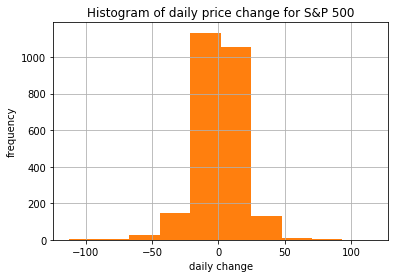

In [39]:
df.change.hist()
ax = df.change.hist()
ax.set(xlabel='daily change', ylabel='frequency', title='Histogram of daily price change for S&P 500')
plt.show()

The above plot is definitely close to normally distributed.  Next, check one more security - gold, for example to see if it has normally distributed data also.

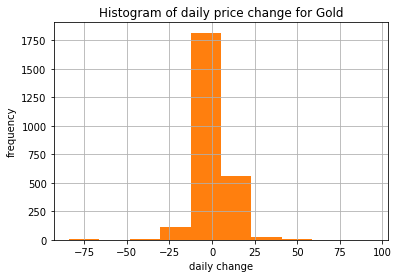

In [40]:
df_gold.change.hist()
ax = df_gold.change.hist()
ax.set(xlabel='daily change', ylabel='frequency', title='Histogram of daily price change for Gold')
plt.show()

This looks close to normal as well.  

Finally, compute the F statistice for the S&P 500 grouped by month:

In [41]:
# Calc F statistic for S&P 500 grouped by month
F, p = stats.f_oneway(
    df['Jan'].dropna(),
    df['Feb'].dropna(),
    df['Mar'].dropna(),
    df['Apr'].dropna(),
    df['May'].dropna(),
    df['June'].dropna(),
    df['July'].dropna(),
    df['Aug'].dropna(),
    df['Sep'].dropna(),
    df['Oct'].dropna(),
    df['Nov'].dropna(),
    df['Dec'].dropna(),
)

# The F statistic.
print(F)

# The probability. A p < .05 would lead us to believe the group means were
# not all similar in the population.
print(p)

0.6825850026550205
0.7563506335281399


Well, the F value is not very high (compared to gold, for example) and the p-value is **0.75** which means there really is no significant difference between the months.  This conflicts with the t-test.  Which one is correct ?  It depends.  If the study comprises the entire population of the data - in other words, all of the returns since its inception - the F statistic is the most relevant metric.  However, it can be argued that the last 10 years of S&P 500 data is just a sample of the overall population - in which case the t-test is the most relevant metric.  

### 2. E.  Question:  Is it possible to build a supervised learning model to predict the daily price change of gold just by using day of the week as the only feature ?  

**Answer:**  Possibly.  The data analysis follows:  

First, set up the dataframe so the change per day is a 1 for positive change and 0 for negative change.  In other words the threshold is 0.  There is only 1 value of 0 in the data, so no need to worry about that.  Next, create columns for each day of the week and signify the day for each row with a 1 (while all other values will be 0).  Note:  It might be reasonable to keep only the 2 most signigicant summations which are Mondays and Thursdays in this case - this was performed and yielded the same results as looking at all 5 days. 

#### Prepare Gold data for building a Supervised Learning model to predict the price change.

In [42]:
df_gold.head()

,DATE,GOLDAMGBD229NLBM,price,date_time,weekday,day,month,year,change,Monday,Tuesday,Wednesday,Thursday,Friday
0,2009-06-26,572.566,572.566,2009-06-26,4,26,6,2009,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-06-29,570.133,570.133,2009-06-29,0,29,6,2009,-2.433,-2.433,NaN,NaN,NaN,NaN
2,2009-06-30,566.697,566.697,2009-06-30,1,30,6,2009,-3.436,NaN,-3.436,NaN,NaN,NaN
3,2009-07-01,567.296,567.296,2009-07-01,2,1,7,2009,0.599,NaN,NaN,0.599,NaN,NaN
4,2009-07-02,571.708,571.708,2009-07-02,3,2,7,2009,4.412,NaN,NaN,NaN,4.412,NaN


In [43]:
# make a copy of this dataframe for later:
df_gold_barplot = df_gold.copy()

In [44]:
df_gold['change'].fillna(0, inplace=True)

df_gold.drop(['DATE'], axis=1, inplace=True)
df_gold.drop(['GOLDAMGBD229NLBM'], axis=1, inplace=True)
df_gold.drop(['price'], axis=1, inplace=True)
df_gold.drop(['date_time'], axis=1, inplace=True)
df_gold.drop(['year'], axis=1, inplace=True)
df_gold.drop(['Monday'], axis=1, inplace=True)
df_gold.drop(['Tuesday'], axis=1, inplace=True)
df_gold.drop(['Wednesday'], axis=1, inplace=True)
df_gold.drop(['Thursday'], axis=1, inplace=True)
df_gold.drop(['Friday'], axis=1, inplace=True)
df_gold.drop(['day'], axis=1, inplace=True)
df_gold.drop(['month'], axis=1, inplace=True)

In [45]:
# make a copy of this dataframe for later:
df_bin = df_gold.copy()

In [46]:
df_gold.head()

,weekday,change
0,4,0.000
1,0,-2.433
2,1,-3.436
3,2,0.599
4,3,4.412


Set up the new format for the gold dataframe:

In [47]:
# Create the 'binary column for positive or negative change
df_gold['binary'] = np.where(df_gold.change >= 0, 1, 0)

# Create the 5 columns for each day of the week
df_gold['zero'] = np.where(df_gold.weekday == 0, 1, 0)
df_gold['one'] = np.where(df_gold.weekday == 1, 1, 0)
df_gold['two'] = np.where(df_gold.weekday == 2, 1, 0)
df_gold['three'] = np.where(df_gold.weekday == 3, 1, 0)
df_gold['four'] = np.where(df_gold.weekday == 4, 1, 0)

# drop 'weekday and change columns'
df_gold.drop(['weekday'], axis=1, inplace=True)
df_gold.drop(['change'], axis=1, inplace=True)

In [48]:
df_gold.head()

,binary,zero,one,two,three,four
0,1,0,0,0,0,1
1,0,1,0,0,0,0
2,0,0,1,0,0,0
3,1,0,0,1,0,0
4,1,0,0,0,1,0


Create the training and test data sets:

In [49]:
# Create training and test sets.
offset_gold = int(df_gold.shape[0] * 0.8)

df_train_gold = df_gold[:offset_gold]
df_test_gold = df_gold[offset_gold:]

print(df_train_gold.shape)
print(df_test_gold.shape)

(2020, 6)
(505, 6)


Try Logistic Regression first:

In [50]:
# 1.  Logistic Regression

from datetime import datetime
start_time = datetime.now()

# Instantiate our model.
regr_gold = linear_model.LogisticRegression()

# set features and dependent variable for training data
y_train_gold = df_train_gold['binary'].values

# drop the 'binary' column to obtain the feature inputs
df_train_gold.drop(['binary'], axis=1, inplace=True)

# normalize the training data
# x_train_bin = sklearn.preprocessing.normalize(df_train_bin)
x_train_gold = df_train_gold

# now for test...
y_test_gold = df_test_gold['binary'].values

# drop the 'binary' column to obtain the feature inputs
df_test_gold.drop(['binary'], axis=1, inplace=True)

# normalize the test data
# x_test_bin = sklearn.preprocessing.normalize(df_test_bin)
x_test_gold = df_test_gold

# fit model to training data
regr_gold.fit(x_train_gold, y_train_gold)

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Duration: 0:00:00.117007


C:\Users\Fred\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\Fred\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Print the results:

In [51]:
# Display the attributes calculated.
print('Coefficients: \n', regr_gold.coef_)
print('Intercept: \n', regr_gold.intercept_)

# print the area under the curve score for the accuracy metric
y_test_pred = regr_gold.predict(x_test_gold)
print(sklearn.metrics.roc_auc_score(y_test_gold, y_test_pred))

# print the consfusion matrix
sklearn.metrics.confusion_matrix(y_test_gold, y_test_pred, labels=None, sample_weight=None)

Coefficients: 
 [[ 0.34285275  0.06100424 -0.02081022 -0.23235677 -0.14899687]]
Intercept: 
 [0.00169314]
0.4866967871485944


array([[149, 100],
       [160,  96]], dtype=int64)

The ROC accuracy score is **0.49** which is just slightly less than the ground truth of 0.50.  Looks like there are a large number of False Positives from the Confusion Matrix (160) relative to the other quadrants.  The Random Forest Classifier algorithm is next:

In [52]:
# 2.  Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

# Instantiate our model.
rfc_gold = RandomForestClassifier(n_estimators=500, max_depth=50)

# fit model to data
rfc_gold.fit(x_train_gold, y_train_gold)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Print the results:

In [53]:
# print the area under the curve score for the accuracy metric
y_test_pred = rfc_gold.predict(x_test_gold)
print(sklearn.metrics.roc_auc_score(y_test_gold, y_test_pred))

# print the consfusion matrix
sklearn.metrics.confusion_matrix(y_test_gold, y_test_pred, labels=None, sample_weight=None)

0.4866967871485944


array([[149, 100],
       [160,  96]], dtype=int64)

Same result as Logistic Regression.  Maybe Gradient Boosting Classifier will work better:

In [54]:
# 3.  Gradient Boosting Classifier

from sklearn.ensemble import GradientBoostingClassifier

# Instantiate our model.
gbc_gold = GradientBoostingClassifier(n_estimators=500)

# fit model to data
gbc_gold.fit(x_train_gold, y_train_gold)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [55]:
# print the area under the curve score for the accuracy metric
y_test_pred = gbc_gold.predict(x_test_gold)
print(sklearn.metrics.roc_auc_score(y_test_gold, y_test_pred))

# print the consfusion matrix
sklearn.metrics.confusion_matrix(y_test_gold, y_test_pred, labels=None, sample_weight=None)

0.4866967871485944


array([[149, 100],
       [160,  96]], dtype=int64)

Hmmmmm.  Same results.  These machine learning methods are not predicting the price change very well.  Is the data balanced ?  In other words, are the number of 1's and 0's about the same ?

In [56]:
print(df_gold.loc[df_gold['binary'] == 1, 'binary'].count())
print(df_gold.loc[df_gold['binary'] == 0, 'binary'].count())

1264
1261


Yes, the data is balanced.  Next, check in another way to see if the days of the week really can be reasonable features for a predictive machine learning model.  See the barplot below (the dataframe used here is called df_gold_barplot which was copied from the original gold dataframe to perserve the actual 'change' values):

C:\Users\Fred\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


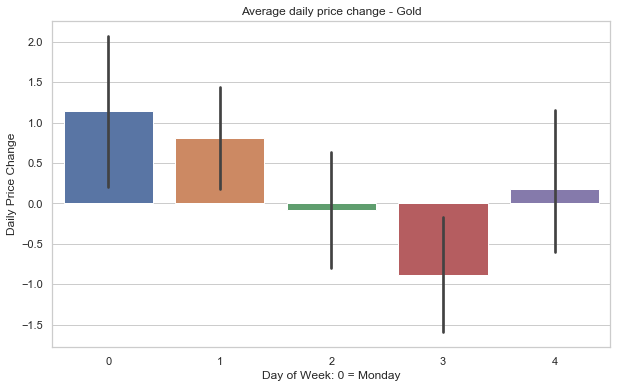

In [57]:
sns.set(style="whitegrid", rc={'figure.figsize':(10, 6)})
sns.barplot(x='weekday', y='change', ci=95, data=df_gold_barplot)
plt.xlabel('Day of Week: 0 = Monday')
plt.ylabel('Daily Price Change')
plt.title('Average daily price change - Gold')
plt.show()

This clearly shows a difference in the day of the week for Mondays and Thursdays at the very least.  With a 95% level of confidence, this shows that the mean range (which is the average daily change over the entire 10 years) of Monday or Tuesday does not even overlap with the mean range on Thursday.  This is illustrated by the vertical black line for each day of the week above.  

There are probably better modeling techniques using machine learning for predicting this price discrepancy.  Many methods were experimented with besides the one shown above.  Using the actual change numbers for a continuous model yielded the same results. 

# 3.  Weather and Financial Data Combined  

This notebook captures the amount of sunshine (in minutes) per day and the daily temperature (in degrees F) in New York City.  The weather data is combined with the 'change' from the financial data above for the S&P 500.  The hypothesis is that there will be better returns on sunny days on average.  There are numerous theories that suggest this correlation.  For example, the following study:  
https://news.fordham.edu/inside-fordham-category/the-sunshine-effect-financial-markets-respond-to-the-weather/  

To validate or invalidate these claims, see the following analysis.  First, the amount of sunhine and its affects is covered; then, the daily temperature data is compared to the daily returns.  

### 3.A. Question:  Does the daily temperature or amount of sunshine in NYC affect the price change of the S&P 500 ?  

**Answer:**  No.  See analysis below.

Set up the data for the two new dataframes - 'dfw' for Sunshine and 'dft' for Temperature.


In [58]:
dfw.head()

,Sun
dt,
2009-06-25,0.00
2009-06-26,418.70
2009-06-27,743.23
2009-06-28,436.08
2009-06-29,848.28


In [59]:
dft.head()

,avg_temp
dt,
2009-06-25,71.72
2009-06-26,76.91
2009-06-27,76.34
2009-06-28,72.35
2009-06-29,75.43


Reset the index of these dataframe in order to merge this data with another dataframe.

In [60]:
# reset the index of this dataframe in order to merge this data with another dataframe
dfw.reset_index(level=0, inplace=True)
dft.reset_index(level=0, inplace=True)

Print the columns of the data frame for S&P 500, drop some unnecessary columns and reset the index for merging data with weather data:

In [61]:
# print columns and reset index
print(df.columns)

# Fill Nan values with 0
df['change'].fillna(0, inplace=True)

# drop unnecessary columns 
df.drop(['DATE'], axis=1, inplace=True)
df.drop(['SP500'], axis=1, inplace=True)
df.drop(['price'], axis=1, inplace=True)
df.drop(['date_time'], axis=1, inplace=True)
df.drop(['year'], axis=1, inplace=True)
df.drop(['Monday'], axis=1, inplace=True)
df.drop(['Tuesday'], axis=1, inplace=True)
df.drop(['Wednesday'], axis=1, inplace=True)
df.drop(['Thursday'], axis=1, inplace=True)
df.drop(['Friday'], axis=1, inplace=True)
df.drop(['Jan'], axis=1, inplace=True)
df.drop(['Feb'], axis=1, inplace=True)
df.drop(['Mar'], axis=1, inplace=True)
df.drop(['Apr'], axis=1, inplace=True)
df.drop(['May'], axis=1, inplace=True)
df.drop(['June'], axis=1, inplace=True)
df.drop(['July'], axis=1, inplace=True)
df.drop(['Aug'], axis=1, inplace=True)
df.drop(['Sep'], axis=1, inplace=True)
df.drop(['Oct'], axis=1, inplace=True)
df.drop(['Nov'], axis=1, inplace=True)
df.drop(['Dec'], axis=1, inplace=True)
df.drop(['summer'], axis=1, inplace=True)
df.drop(['winter'], axis=1, inplace=True)
df.drop(['yr3s'], axis=1, inplace=True)
df.drop(['yr3w'], axis=1, inplace=True)
df.drop(['yr3w_2'], axis=1, inplace=True)
df.drop(['yr3w_t'], axis=1, inplace=True)

# reset index for merging data with weather data
df.reset_index(level=0, inplace=True)

Index(['DATE', 'SP500', 'price', 'date_time', 'weekday', 'day', 'month',
       'year', 'change', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'summer', 'winter', 'yr3s', 'yr3w', 'yr3w_2', 'yr3w_t', 'Jan',
       'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov',
       'Dec'],
      dtype='object')


In [62]:
df.tail()

,DATE,weekday,day,month,change
2511,2019-06-19,2,19,6,8.71
2512,2019-06-20,3,20,6,27.72
2513,2019-06-21,4,21,6,-3.72
2514,2019-06-24,0,24,6,-5.11
2515,2019-06-25,1,25,6,-27.97


The dataframe shown above has the financial data needed.  The next step is to merge the weather data with the financial data for the S&P 500:

In [63]:
# create dataframe for S&P 500 and Sunshine in NYC in minutes
df_sun = (dfw.merge(df, left_on='dt', right_on='DATE')
          .reindex(columns=['DATE', 'weekday', 'day', 'month', 'change', 'Sun']))

# create dataframe for S&P 500 and Temperature in NYC
df_temp = (dft.merge(df, left_on='dt', right_on='DATE')
          .reindex(columns=['DATE', 'weekday', 'day', 'month', 'change', 'avg_temp']))

# create dataframe for S&P 500, Temperature and Sunshine in NYC
df_both = (dft.merge(df_sun, left_on='dt', right_on='DATE')
          .reindex(columns=['DATE', 'weekday', 'month', 'day', 'change', 'avg_temp', 'Sun']))


In [64]:
df_temp.head()

,DATE,weekday,day,month,change,avg_temp
0,2009-06-26,4,26,6,0.00,76.91
1,2009-06-29,0,29,6,8.33,75.43
2,2009-06-30,1,30,6,-7.91,77.41
3,2009-07-01,2,1,7,4.01,73.40
4,2009-07-02,3,2,7,-26.91,71.23


The above dataframe shows the merged S&P data with the temperature data.  Next, print the average of the average daily temps:

In [65]:
print(df_temp.avg_temp.mean())

55.04181240063589


In [66]:
df_sun.head()

,DATE,weekday,day,month,change,Sun
0,2009-06-26,4,26,6,0.00,418.70
1,2009-06-29,0,29,6,8.33,848.28
2,2009-06-30,1,30,6,-7.91,608.00
3,2009-07-01,2,1,7,4.01,168.86
4,2009-07-02,3,2,7,-26.91,225.66


The above dataframe shows the "change" for the S&P 500 and the "Sun" for the number of hours of sunshine by date.

This next step counts the number of hours when the hours of **sunshine is greater than 300** and less than 300.  This cutoff of 300 is a good number because it has roughly the same amount of days above and below the threshold, keeping our data balanced.  

Also, 4 new columns in the temperature dataframe are created to separate the data above and below the average temperature of **55 degrees Farenheit**.

In [67]:
# Creae 4 new columns in the df_out dataframe
df_sun['sun_300'] = np.where(df_sun.Sun >= 300.0, 1, 0)
df_sun['less_300'] = np.where(df_sun.Sun < 300.0, 1, 0)
df_sun['value_3'] = np.where(df_sun.Sun >= 300.0, df_sun.change, 0)
df_sun['value_3_less'] = np.where(df_sun.Sun < 300.0, df_sun.change, 0)

# Creae 4 new columns in the df_out_temp dataframe
df_temp['tmp_55'] = np.where(df_temp.avg_temp >= 55.0, 1, 0)
df_temp['less_55'] = np.where(df_temp.avg_temp < 55.0, 1, 0)
df_temp['value_55'] = np.where(df_temp.avg_temp >= 55.0, df_temp.avg_temp, 0)
df_temp['value_55_less'] = np.where(df_temp.avg_temp < 55.0, df_temp.avg_temp, 0)

In [68]:
df_sun.head(10)

,DATE,weekday,day,month,change,Sun,sun_300,less_300,value_3,value_3_less
0,2009-06-26,4,26,6,0.00,418.70,1,0,0.00,0.00
1,2009-06-29,0,29,6,8.33,848.28,1,0,8.33,0.00
2,2009-06-30,1,30,6,-7.91,608.00,1,0,-7.91,0.00
3,2009-07-01,2,1,7,4.01,168.86,0,1,0.00,4.01
4,2009-07-02,3,2,7,-26.91,225.66,0,1,0.00,-26.91
5,2009-07-06,0,6,7,2.30,787.34,1,0,2.30,0.00
6,2009-07-07,1,7,7,-17.69,291.83,0,1,0.00,-17.69
7,2009-07-08,2,8,7,-1.47,636.53,1,0,-1.47,0.00
8,2009-07-09,3,9,7,3.12,639.93,1,0,3.12,0.00
9,2009-07-10,4,10,7,-3.55,895.12,1,0,-3.55,0.00


In [69]:
df_temp.head()

,DATE,weekday,day,month,change,avg_temp,tmp_55,less_55,value_55,value_55_less
0,2009-06-26,4,26,6,0.00,76.91,1,0,76.91,0.0
1,2009-06-29,0,29,6,8.33,75.43,1,0,75.43,0.0
2,2009-06-30,1,30,6,-7.91,77.41,1,0,77.41,0.0
3,2009-07-01,2,1,7,4.01,73.40,1,0,73.40,0.0
4,2009-07-02,3,2,7,-26.91,71.23,1,0,71.23,0.0


This next step defines some variables to count the number of days when the sunshine hours is above or below a specific threshold; and defines variables that counts the actual points gained or loss over the horizon for each of the two groups.  

Temperature data is counted, summed and analyzed as well.

In [70]:
# FOR SUNSHINE
# count number of days where sunshine is at least 300 hours
a = df_sun.sun_300.sum()

# count number of days where sunshine is less than 300 hours
a_less = df_sun.less_300.sum()

# calculate the points gained when sunshine is at least 300 hours
b = np.where(df_sun.Sun >= 300.0, df_sun.change, 0).sum()

# calculate the points gained when sunshine is less than 300 hours
c = np.where(df_sun.Sun < 300.0, df_sun.change, 0).sum()

# FOR TEMPERATURE 
# count number of days where temp is at least 55 degrees F
at = df_temp.tmp_55.sum()

# count number of days where temp is less than 55
at_less = df_temp.less_55.sum()

# calculate the points gained when temp is at least 55
bt = np.where(df_temp.avg_temp >= 55.0, df_temp.change, 0).sum()

# calculate the points gained when temp is less than 55
ct = np.where(df_temp.avg_temp < 55.0, df_temp.change, 0).sum()

Print the results:

In [71]:
# FOR SUNSHINE
print('\nTotal number of days when sun hours is greater than 300:')
print(a)
print('\nTotal number of days when sun hours is less than 300:')
print(a_less)
print('\nTotal points gained in S&P 500 when number of sun hours is greater than 300:')
print(b)
print('\nTotal points gained in S&P 500 when number of sun hours is less than 300:')
print(c)

# FOR TEMPERATURE
print('\nTotal number of days when temperature is greater than or equal to 55:')
print(at)
print('\nTotal number of days when temp is less than 55:')
print(at_less)
print('\nTotal points gained in S&P 500 when temp is greater than 55:')
print(bt)
print('\nTotal points gained in S&P 500 when temp is less than 55:')
print(ct)


Total number of days when sun hours is greater than 300:
1295

Total number of days when sun hours is less than 300:
1221

Total points gained in S&P 500 when number of sun hours is greater than 300:
1159.2999999999988

Total points gained in S&P 500 when number of sun hours is less than 300:
839.1800000000013

Total number of days when temperature is greater than or equal to 55:
1314

Total number of days when temp is less than 55:
1202

Total points gained in S&P 500 when temp is greater than 55:
1038.2800000000007

Total points gained in S&P 500 when temp is less than 55:
960.1999999999994


Next, compare the average daily gain / loss of S&P 500 when sunshine hours is greater or less than 300 minutes per day.

In [72]:
# FOR SUNSHINE
print('\nAverage daily gain of S&P 500 when sun hours is greater than 300:')
print(b/a)

print('\nAverage daily gain of S&P 500 when sun hours is less than 300:')
print(c/a_less)

# FOR TEMPERATURE
print('\nAverage daily gain of S&P 500 when avg temperature is greater than 55:')
print(bt/at)

print('\nAverage daily gain of S&P 500 when avg temp is less than 55:')
print(ct/at_less)


Average daily gain of S&P 500 when sun hours is greater than 300:
0.8952123552123543

Average daily gain of S&P 500 when sun hours is less than 300:
0.6872891072891084

Average daily gain of S&P 500 when avg temperature is greater than 55:
0.7901674277016748

Average daily gain of S&P 500 when avg temp is less than 55:
0.7988352745424288


Is this difference signficant for the **sunshine** data ?  Remember that the overall average for all days over the 10 year period is **0.794** calculated earlier in this notebook.  

Obviously, the difference in average price gain / loss for the two different **temperature** distributions is not significant.  The avg daily gain is **0.790** and **0.800** for days above 55 degrees F and below 55, respectively. 

Let's quickly try the differences for over 75 degree F vs under 35 degree F cutoff:

In [73]:
# Creae 4 new columns in the df_out_temp dataframe
df_temp['tmp_75'] = np.where(df_temp.avg_temp > 75.0, 1, 0)
df_temp['tmp_35'] = np.where(df_temp.avg_temp < 35.0, 1, 0)
df_temp['value_75'] = np.where(df_temp.avg_temp > 75.0, df_temp.avg_temp, 0)
df_temp['value_35'] = np.where(df_temp.avg_temp < 35.0, df_temp.avg_temp, 0)
df_temp['change_75'] = np.where(df_temp.avg_temp > 75.0, df_temp.change, 0)
df_temp['change_35'] = np.where(df_temp.avg_temp < 35.0, df_temp.change, 0)

# drop unnecessary columns
df_temp.drop(['tmp_55'], axis=1, inplace=True)
df_temp.drop(['less_55'], axis=1, inplace=True)
df_temp.drop(['value_55'], axis=1, inplace=True)
df_temp.drop(['value_55_less'], axis=1, inplace=True)

The dataframe below was created to count the days when the temp is above 75 or below 35 and to compare the two distributions with statistical tests later.

In [74]:
df_temp.head()

,DATE,weekday,day,month,change,avg_temp,tmp_75,tmp_35,value_75,value_35,change_75,change_35
0,2009-06-26,4,26,6,0.00,76.91,1,0,76.91,0.0,0.00,0.0
1,2009-06-29,0,29,6,8.33,75.43,1,0,75.43,0.0,8.33,0.0
2,2009-06-30,1,30,6,-7.91,77.41,1,0,77.41,0.0,-7.91,0.0
3,2009-07-01,2,1,7,4.01,73.40,0,0,0.00,0.0,0.00,0.0
4,2009-07-02,3,2,7,-26.91,71.23,0,0,0.00,0.0,0.00,0.0


In [75]:
# FOR TEMPERATURE 
# count number of days where temp is at least 55 degrees F
a_75 = df_temp.tmp_75.sum()

# count number of days where temp is less than 55
a_35 = df_temp.tmp_35.sum()

# calculate the points gained when temp is at least 55
b_75 = np.where(df_temp.avg_temp > 75.0, df_temp.change, 0).sum()

# calculate the points gained when temp is less than 55
c_35 = np.where(df_temp.avg_temp < 35.0, df_temp.change, 0).sum()

Next, print the results for comparing the two distributions.

In [76]:
# FOR TEMPERATURE
print('\nTotal number of days when temperature is greater than 75:')
print(a_75)
print('\nTotal number of days when temp is less than 35:')
print(a_35)
print('\nTotal points gained in S&P 500 when temp is greater than 75:')
print(b_75)
print('\nTotal points gained in S&P 500 when temp is less than 35:')
print(c_35)


Total number of days when temperature is greater than 75:
364

Total number of days when temp is less than 35:
405

Total points gained in S&P 500 when temp is greater than 75:
-83.90999999999872

Total points gained in S&P 500 when temp is less than 35:
411.7500000000002


In [77]:
# FOR TEMPERATURE
print('\nAverage daily gain of S&P 500 when avg temperature is greater than 75:')
print(b_75/a_75)

print('\nAverage daily gain of S&P 500 when avg temp is less than 35:')
print(c_35/a_35)


Average daily gain of S&P 500 when avg temperature is greater than 75:
-0.2305219780219745

Average daily gain of S&P 500 when avg temp is less than 35:
1.0166666666666673


Is this significant ?  The next step is to compute the pvalue with a ttest:

In [78]:
# For temp greater than 75 vs less than 35
ttest_ind(df_temp['change_75'].dropna(), df_temp['change_35'].dropna())

Ttest_indResult(statistic=-1.0460206812846735, pvalue=0.29560174677866946)

Since the pvalue is **0.295**, the difference in daily price change values is not significant.  This calculation shows that there is about a 30% chance that the difference in the results were due to randam chance.

The next graph shows the visual relationship between the temperature and all of the daily change values.  From a quick scan, it looks like the returns above and below the 35 and 75 thresholds are fairly evenly distributed:  

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


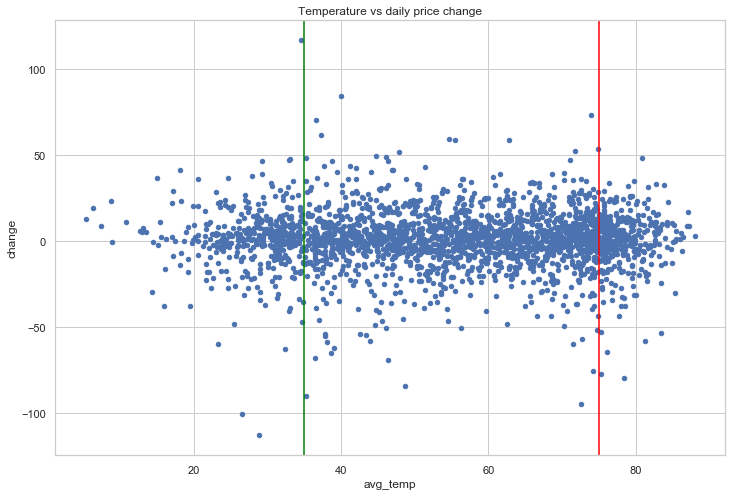

In [79]:
df_temp.plot(kind='scatter', x='avg_temp', y='change', title='Temperature vs daily price change', 
                 figsize=(12, 8), grid=True)
plt.axvline(x=35.0, color='green')
plt.axvline(x=75.0, color='red')

As stated above, this scatter plot shows a fairly even distibution of daily price change above and below the thresholds.

Now, going back to analyzing Sunshine, compare the results using a **500 daily minutes** of sun cutoff.  This is the same process and code as above only using a cutoff value of 500 instead of 300.

In [80]:
df_sun['sun_500'] = np.where(df_sun.Sun >= 500.0, 1, 0)
df_sun['less_500'] = np.where(df_sun.Sun < 500.0, 1, 0)
df_sun['value_5'] = np.where(df_sun.Sun >= 500.0, df_sun.change, 0)
df_sun['value_5_less'] = np.where(df_sun.Sun < 500.0, df_sun.change, 0)

In [81]:
x = df_sun.sun_500.sum()
x_less = df_sun.less_500.sum()
y = np.where(df_sun.Sun >= 500.0, df_sun.change, 0).sum()
z = np.where(df_sun.Sun < 500.0, df_sun.change, 0).sum()

Print the results:

In [82]:
print('\nTotal number of days when sun hours is greater than 500:')
print(x)

print('\nTotal number of days when sun hours is less than 500:')
print(x_less)

print('\nTotal points gained in S&P 500 when number of sun hours is greater than 500:')
print(y)

print('\nTotal points gained in S&P 500 when number of sun hours is less than 500:')
print(z)


Total number of days when sun hours is greater than 500:
902

Total number of days when sun hours is less than 500:
1614

Total points gained in S&P 500 when number of sun hours is greater than 500:
589.170000000003

Total points gained in S&P 500 when number of sun hours is less than 500:
1409.3099999999972


Print the average daily gains of the two different groups.

In [83]:
print('\nAverage daily gain of S&P 500 when sun hours is greater than 500:')
print(y/x)

print('\nAverage daily gain of S&P 500 when sun hours is less than 500:')
print(z/x_less)


Average daily gain of S&P 500 when sun hours is greater than 500:
0.6531818181818215

Average daily gain of S&P 500 when sun hours is less than 500:
0.8731784386617083


Are these daily differences significant ?  This is strange: now the average is greater in the 'less than' group.

What about the days when the number of sunsine hours is greater or less than **700** ?  This is the same process and code as above only using a cutoff value of 700/300 instead of 300 or 500.  Create the new columns in the dataframe:

In [84]:
df_sun['sun_700'] = np.where(df_sun.Sun >= 700.0, 1, 0)
df_sun['less_700'] = np.where(df_sun.Sun < 700.0, 1, 0)
df_sun['value_7'] = np.where(df_sun.Sun >= 700.0, df_sun.change, 0)
df_sun['value_7_less'] = np.where(df_sun.Sun < 700.0, df_sun.change, 0)

d = df_sun.sun_700.sum()
d_less = df_sun.less_700.sum()
e = np.where(df_sun.Sun >= 700.0, df_sun.change, 0).sum()
f = np.where(df_sun.Sun < 700.0, df_sun.change, 0).sum()

Print the results:

In [85]:
print('\nTotal number of days when sun hours is greater than 700:')
print(d)

print('\nTotal number of days when sun hours is less than 700:')
print(d_less)

print('\nTotal points gained in S&P 500 when number of sun hours is greater than 700:')
print(e)

print('\nTotal points gained in S&P 500 when number of sun hours is less than 700:')
print(f)


Total number of days when sun hours is greater than 700:
373

Total number of days when sun hours is less than 700:
2143

Total points gained in S&P 500 when number of sun hours is greater than 700:
211.11999999999966

Total points gained in S&P 500 when number of sun hours is less than 700:
1787.3600000000006


Print the average daily gains of the two different groups.

In [86]:
print('\nAverage daily gain of S&P 500 when sun hours is greater than 700:')
print(e/d)

print('\nAverage daily gain of S&P 500 when sun hours is less than 700:')
print(f/d_less)


Average daily gain of S&P 500 when sun hours is greater than 700:
0.566005361930294

Average daily gain of S&P 500 when sun hours is less than 700:
0.834045730284648


Are these daily averge differences significant ?  It seems odd that the daily average gain for days with more than 300 minutes is larger than those days with less than 300.  However, the reverse is true for days where the cutoff of sunshine hours is 500 and 700.  In other words, the average daily price where sunshine hours is more than 500 and 700, is less than the gain on days where there is less than 500 and 700 hours of sun, respectively.  What is going on here ?  The next step uses a t-test to determine the significance of the results.

In [87]:
# For sunshine more than 300 vs less than 300
ttest_ind(df_sun['value_3'].dropna(), df_sun['value_3_less'].dropna())

Ttest_indResult(statistic=0.3810877859627107, pvalue=0.7031542048478165)

In [88]:
# For sunshine more than 500 vs less than 500
ttest_ind(df_sun['value_5'].dropna(), df_sun['value_5_less'].dropna())

Ttest_indResult(statistic=-0.9764164785096374, pvalue=0.328905074534642)

In [89]:
# For sunshine more than 700 vs less than 700
ttest_ind(df_sun['value_7'].dropna(), df_sun['value_7_less'].dropna())

Ttest_indResult(statistic=-1.877069483932292, pvalue=0.06056640489040069)

From these Ttests, none of the differences are significant; all could have happened due to random chance.  However, for days more or less than 700 minutes of sun, the pvalue is just slightly above 0.05 (actual value = 0.061).  Remember, the average gain was higher where number of sunshine minutes was less than 700.  This could be due to the fact that the winter months in general perform better than the summer months, but it could also de due to randome chance.  The p-value is not low enough to draw a concrete conclusion.   

The following plot shows the relationship between amount of daily sunhine vs. daily price change.  This should help to further clarify whether a true difference exists.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


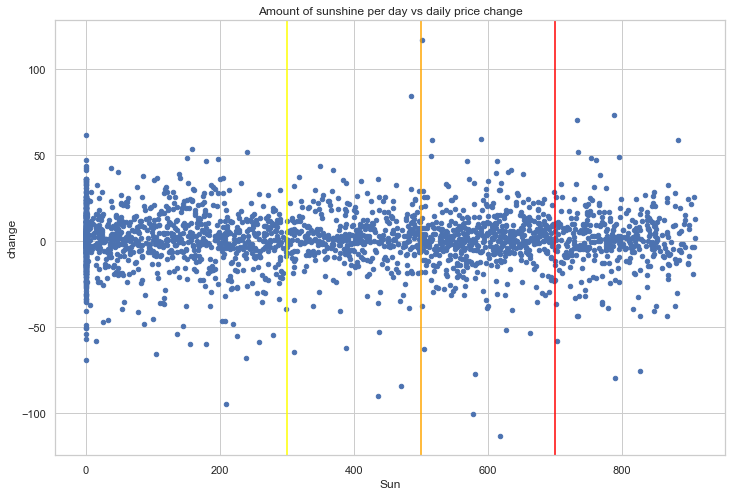

In [90]:
df_sun.plot(kind='scatter', x='Sun', y='change', title='Amount of sunshine per day vs daily price change', 
                 figsize=(12, 8), grid=True)
plt.axvline(x=300, color='yellow')
plt.axvline(x=500, color='orange')
plt.axvline(x=700, color='red')

As the calculations and significance tests above show, it looks like there really is not a significant correlation between the amount of daily sunshine in New York City and the price change of the S&P 500 over the last 10 years.  The winter (and thus less sunny) months might perform slightly better, but very difficult to see any evidence of that in the above scatter plot.  **The safest conclusion and the conclusion best supported by the data is that there really is no signficant difference in daily returns regardless of the season or the amount of sunshine or the average daily temperature**. 

### 3.B.  Question: Is it possible to build a supervised learning model that uses the day of the week, month, day of month and weather data to predict daily price change of the S&P 500 ?

First, show the dataframe created earlier that has the day of week, month and day of month - along with the daily price change, average daily temperature and daily sunshine minutes.

In [91]:
df_both.head()

,DATE,weekday,month,day,change,avg_temp,Sun
0,2009-06-26,4,6,26,0.00,76.91,418.70
1,2009-06-29,0,6,29,8.33,75.43,848.28
2,2009-06-30,1,6,30,-7.91,77.41,608.00
3,2009-07-01,2,7,1,4.01,73.40,168.86
4,2009-07-02,3,7,2,-26.91,71.23,225.66


These will be regression models because the dependent variable that will be predicted is daily price change, which is continuous.  First, set up the training and test data sets like we did before.

In [92]:
# drop the 'DATE' column because it is not needed; the date elements are already included
df_both.drop(['DATE'], axis=1, inplace=True)

# Create training and test sets.
offset_both = int(df_both.shape[0] * 0.8)

# set the training and test set dataframes according to the split in the previous line of code
df_train_both = df_both[:offset_both]
df_test_both = df_both[offset_both:]

# print the number of rows and columns for the new dataframes
print(df_train_both.shape)
print(df_test_both.shape)

(2012, 6)
(504, 6)


As shown above, the new dataframs have 7 columns and the training consists of 80% of the data while 20% is reserved for the test set.  

Try **Linear Regression** first:

In [93]:
# 1.  Linear Regression

from datetime import datetime
start_time = datetime.now()

# Instantiate our model.
regr_both = linear_model.LinearRegression()

# set features and dependent variable for training data
y_train_both = df_train_both['change'].values

# drop the 'change' column to obtain the feature inputs
df_train_both.drop(['change'], axis=1, inplace=True)

# normalize the training data
x_train_both = sklearn.preprocessing.normalize(df_train_both)
# x_train_gold = df_train_gold

# now for test...
y_test_both = df_test_both['change'].values

# drop the 'change' column to obtain the feature inputs
df_test_both.drop(['change'], axis=1, inplace=True)

# normalize the test data
x_test_both = sklearn.preprocessing.normalize(df_test_both)
# x_test_gold = df_test_gold

# fit model to training data
regr_both.fit(x_train_both, y_train_both)

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Duration: 0:00:00.115007


C:\Users\Fred\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\Fred\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


After fitting the model above, print the results below:

In [94]:
# Display the attributes we calculated.
print('Coefficients: \n', regr_both.coef_)
print('Intercept: \n', regr_both.intercept_)
print('\nR-squared train:')
print(regr_both.score(x_train_both, y_train_both))

print('\nR-squared test:')
print(regr_both.score(x_test_both, y_test_both))

Coefficients: 
 [ 3.57756166  3.10150904 -1.47460292  2.47753905  2.06545587]
Intercept: 
 -1.7000859217184647

R-squared train:
0.0006136080436329738

R-squared test:
-0.0020524175019946966


Not too surprising.  The prediction scores are close to zero.  Since there was no correlation with the weather data and the supervised model created and executed earlier in this notebook did not yield useful results, this model as well, is not very helpful.  The Random Forest Regressor algorithm and Gradient Boosting Regression are shown next.  The expectation is that these models also will not yield helpful results, however, a check is needed in the following steps just to make sure.  **Random Forest Regressor** is next:

In [95]:
# 2.  Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor

# Instantiate our model.
rfr_both = RandomForestRegressor(n_estimators=500, max_depth=10)

# fit model to data
rfr_both.fit(x_train_both, y_train_both)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

The fit is performed above, the results are next:

In [96]:
# Display the score for training and test:

print('\nR-squared train:')
print(rfr_both.score(x_train_both, y_train_both))

print('\nR-squared test:')
print(rfr_both.score(x_test_both, y_test_both))


R-squared train:
0.3115781775211953

R-squared test:
-0.01245617691722778


This is interesting - the score for training is reasonably high, however, score for test is very low.  Looks like the model is overfit.  Note:  A hyperparameter of max_depth=50 was used and the R-square for train came out to be 0.84 which is even more overfit.  **Gradient Boosting** is next:

In [97]:
# 3.  Gradient Boosting Regressor

from sklearn.ensemble import GradientBoostingRegressor

# Instantiate our model
gbr_both = GradientBoostingRegressor(n_estimators=500)

# fit model to data
gbr_both.fit(x_train_both, y_train_both)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [98]:
# Display the score for training and test:

print('\nR-squared train:')
print(gbr_both.score(x_train_both, y_train_both))

print('\nR-squared test:')
print(gbr_both.score(x_test_both, y_test_both))


R-squared train:
0.6025383942041649

R-squared test:
-0.08144184855013004


Here again, a solid accuracy score for the training data, but not useful for test data.  The two dataframes - training and test - have a high degree of variance with these particular parameters.  In conclusion, it is very hard to build a supervised model to predict the daily change in price for the S&P 500 given data data and weather data.  

A final section of this notebook is dedicated to supervised learning methods to determine if some kind of relationship or relationships can be derived by looking at the price change for each of the 5 securities (S&P 500, 10 Yr Bond, Gold, Oil, Bitcoin) over the past 10 years.  In other words, maybe one or more of these securities move together or maybe some move in opposite directions and are thus negatively correlated.  The goal is to look for some kind of cluster or grouping of securities in order to take strategic action in the future.  For example, if gold and oil move together - since they are both commodities - maybe holding both of these commodities in a portfolio is not necessary.  Or, another strategy could be to buy one of the commodities if the other has moved up considerably (comparatively) in the recent past.  

### 3.C. Question:  Is it possible to build an unsupervised learning model to identify relationships among the 4 securites previously analyzed in this study ?  

**Answer:**  Possibly.  See analysis below.

Set up the new dataframe which will constist of all of the daily 'change' values for each of the 4 securities over the past 10 years.  Bitcoin 'change' data is not included because the data only covers about 4.5 years.  

First, look at the dataframes and rename some columns to merge the dataframes with the relevent information.

In [99]:
df.head()

,DATE,weekday,day,month,change
0,2009-06-26,4,26,6,0.00
1,2009-06-29,0,29,6,8.33
2,2009-06-30,1,30,6,-7.91
3,2009-07-01,2,1,7,4.01
4,2009-07-02,3,2,7,-26.91


In [100]:
df_10_10.head()

,DATE,DGS10,price,date_time,weekday,day,month,year,change,Monday,Tuesday,Wednesday,Thursday,Friday
0,2009-06-26,3.52,3.52,2009-06-26,4,26,6,2009,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-06-29,3.51,3.51,2009-06-29,0,29,6,2009,-0.01,-0.01,NaN,NaN,NaN,NaN
2,2009-06-30,3.53,3.53,2009-06-30,1,30,6,2009,0.02,NaN,0.02,NaN,NaN,NaN
3,2009-07-01,3.55,3.55,2009-07-01,2,1,7,2009,0.02,NaN,NaN,0.02,NaN,NaN
4,2009-07-02,3.51,3.51,2009-07-02,3,2,7,2009,-0.04,NaN,NaN,NaN,-0.04,NaN


The 'change' column of the above 2 dataframes needs to be combined into 1 dataframe and labeled correctly.  The following code renames the 'change' column for the appropriate security; then the 10 Yr Bond data is merged with the S&P data; then the gold and oil 'change' values are added to the final dataframe.

In [101]:
df_10_10.head()

,DATE,DGS10,price,date_time,weekday,day,month,year,change,Monday,Tuesday,Wednesday,Thursday,Friday
0,2009-06-26,3.52,3.52,2009-06-26,4,26,6,2009,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-06-29,3.51,3.51,2009-06-29,0,29,6,2009,-0.01,-0.01,NaN,NaN,NaN,NaN
2,2009-06-30,3.53,3.53,2009-06-30,1,30,6,2009,0.02,NaN,0.02,NaN,NaN,NaN
3,2009-07-01,3.55,3.55,2009-07-01,2,1,7,2009,0.02,NaN,NaN,0.02,NaN,NaN
4,2009-07-02,3.51,3.51,2009-07-02,3,2,7,2009,-0.04,NaN,NaN,NaN,-0.04,NaN


In [102]:
# change the 'change' column of the following dataframes:
df_10_10.rename(columns={'change': 'change_10'}, inplace=True)
df_goldc.rename(columns={'change': 'change_g'}, inplace=True)
df_oil.rename(columns={'change': 'change_o'}, inplace=True)
df_btc.rename(columns={'change': 'change_b'}, inplace=True)

# add the 'dt' column to merge:
df['dt'] = df['DATE']

# drop the ambiquous 'DATE' columns for merging:
# df_10_10.drop(['DATE'], axis=1, inplace=True)

# create dataframe for all 5 securites:
df_all = (df_10_10.merge(df, left_on='date_time', right_on='dt')
          .reindex(columns=['dt', 'change', 'change_10']))

# create the columns for gold and oil:
df_all['change_g'] = df_goldc['change_g']
df_all['change_o'] = df_oil['change_o']

# Fill Nan values with 0
df_all['change_g'].fillna(0, inplace=True)
df_all['change_o'].fillna(0, inplace=True)
df_all['change_10'].fillna(0, inplace=True)

The dataframe with 10 years of daily historical price change for the S&P 500, 10 Yr Bond, Gold, and Oil is shown below:

In [103]:
df_all.tail()

,dt,change,change_10,change_g,change_o
2492,2019-06-19,8.71,-0.03,-4.03,-0.98
2493,2019-06-20,27.72,-0.02,-0.53,-1.13
2494,2019-06-21,-3.72,0.06,2.46,1.49
2495,2019-06-24,-5.11,-0.05,-11.58,0.28
2496,2019-06-25,-27.97,-0.02,1.74,-0.25


Next, look at a pairplot to check out the relationships:

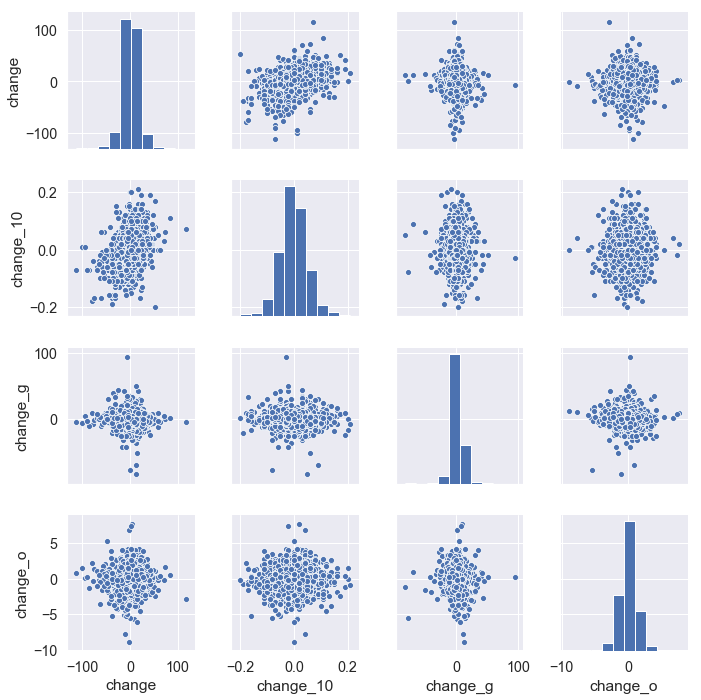

In [104]:
# set the pairplot parameters
sns.set(font_scale=1.3)
sns.pairplot(df_all)
plt.show()

The plot above shows that there might be a significant relationship between 'change' and 'change_10' - that is, as the daily change of the S&P 500 moves higher, the daily change in interest rate of the 10 Yr bond moves higher as well.  It doesn't look like an extremely strong correlation, but it does appear to exist.  The other relationships look fairly random.

#### Unsupervised:  K-Means  

The features for these unsupervised models will be the change values for the 10 Yr Bond, Gold, and Oil.  Then, the change value of the S&P 500 is converted to binary (1 for up, 0 for down) and is captured for the dependent variable.  The idea is to explore if there are clusters of data that correspond to a positive or negative daily move of the S&P 500.  

First, define the features and the dependent variable.

In [105]:
# Define the features and the outcome.
x = df_all.iloc[:, 2:5]
y = df_all['change'].values

# Binarize y so that 1 means the S&P 500 went up; 0 means it went down or stayed at 0.
y = np.where(y > 0, 1, 0)

Next, normalize the data, fit the KMeans clustering algorithm to the data and analyze the results using the actual value of the y value with the predicted y value for each cluster.  Three clusters was chosen because there are 3 columns of features. 

In [106]:
# Normalize the data.
x_norm = normalize(x)

# Calculate predicted values.
y_pred = KMeans(n_clusters=10, random_state=42).fit_predict(x_norm)

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y, y_pred))

Comparing k-means clusters against the data:
col_0    0    1   2   3   4    5   6    7   8   9
row_0                                            
0      288  277  44  38  42  130  64  131  74  42
1      353  343  69  49  52  163  71  145  79  43


Here, it looks like there really is not a significant clustering of the data into the 0 or 1 target.  For cluster 0, there were 288 data points for a 0 label and 353 data points for the 1 label.  Similarly, the other clusters were fairly evenly distributed.

#### Unsupervised:  Mean Shift  

Mean Shift is another clustering method which will determine the number of clusters that best fit the data.

In [107]:
# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(x_norm, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(x_norm)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))


Number of estimated clusters: 8


So, the number of clusters came to be 8 and the crosstab results are given below:

In [108]:
print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y, labels))

Comparing the assigned categories to the ones in the data:
col_0    0    1   2   3  4   5  6  7
row_0                               
0      480  481  54  83  1  28  1  2
1      576  583  88  93  2  25  0  0


From the 8 clusters above, most of the data points were placed in either cluster 0 or cluster 1.  

# Conclusion  

In conclusion, the questions asked at the beginning of this notebook and the answers are summarized below:  

2.A.  Do different days of the week yield significant price change ?  

Definitely yes, for some securities.  For the 10 Yr Bond - Wednesdays were better than Friday with a p-value of **0.0266**; for gold - Mondays were better than Thursdays with p-value of **0.0009**; for bitcoin - Saturdays were better than Thursdays with p-value of **0.0213**.  

2.B.  Do 'winter' months perform better than 'summer' months ?  

No, although the winter months did have a slightly higher average rate of return per day, the p-value to compare the two was **0.3323**.  This is definitely not low enough to conclude there really is a statistical difference.  

2.C.  Does the 3rd Presidential Year yield better results in the 'winter' months vs. 'summer' ?  

No, again, the winter months performed better, but not enough to concluded there is a significant difference.  The p-value was **0.1337**. 

2.D.  Does any month of the S&P 500 over the past 10 years perform significantly better than any other ?  

Yes, July - which was the best performing month - performed statistically signigicantly better than May - which was the worst performing month.  The calculated p-value is **0.0309**.  This isn't a slam dunk metric of significance, but it is less than 0.05 which is the common cutoff for defining significance.

2.E.  Is it possible to build a supervised learning model to predict the daily price change of gold just by using day of the week as the only feature ?  

Possibly, however, the methods used in this study were not conclusive.

3.A.  Does the daily temperature or amount of sunshine in NYC affect the price change of the S&P 500 ?  

**No**, this notebook found no correlation between the amount of sunshine or temperature in NYC ove the last 10 years with the daily price change of the S&P 500.  All of the p-values were found to be above 0.05.  (It might be interesting to check if the amount of snowfall has an impact on daily price change for the S&P 500.)

3.B.  Is it possible to build a supervised learning model that uses the day of the week, month, day of month and weather data to predict daily price change of the S&P 500 ?  

It might be possible, but certainly difficult.  The day of the week mattered as found above, but the month, day of month and weather data may introduce too much noise to build a reasonably affective model.

3.C.  Is it possible to build an unsupervised learning model to identify relationships among the 5 securites previously analyzed in this study ?  

Possibly, more study is needed.  There are cetainly many different ways to structure the model.  Only one method was explored in this notebook.  For instance, a separate feature could be introduced that binarizes daily gold prices, uses that as the dependent variable and uses the actual daily price change of all 5 securities introduced in this notebook as the features.  It could be possible, however, that there is not a predictable pattern.  Furthermore, the pairplot does not show any kind of positive or negative correlation between the 10 Yr Bond, Gold or Oil.   

As a final summary, it was interesting to see that the day of the week appears to play a signigicant role among certain securities.  This could be converted to profitable trading or investing opportunity.  Also, it was interesting and surprising to see that the amount of sunshine or temperature in NYC had virtually no affect on daily price change.  The barplots presented in that corresponding section above provides a quick and easy to read visual of this statistical finding. 